<a href="https://colab.research.google.com/github/HILALOZTEMEL/Text-Generation-Model/blob/main/TextGenerationModel_Hilal_%C3%96ztemel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.utils import np_utils

# set seeds for reproducability

import tensorflow as tf
from numpy.random import seed
tf.random.set_seed(2) 
seed(1)


import pandas as pd
import numpy as np
import string, os 


#kimlik doğrulama işlemi :drive in içinde çalışma ortamı sağlarız serverlarda
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

#Uyarı için , ignore : eşleşen uyarıları asla yazdırma demek.
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

Mounted at /gdrive
/gdrive


In [ ]:
curr_dir = '/gdrive/My Drive/İstanbul Gedik Üniversitesi/natural language preccesing/Dataset/' #veri seti okunur 
all_headlines = [] #veri setinde çok fazla başlık olduğu için bunu bir listede tutarız.
for filename in os.listdir(curr_dir):
    if 'Articles' in filename:
        article_df = pd.read_csv(curr_dir + filename)
        all_headlines.extend(list(article_df.headline.values))
        break

all_headlines = [h for h in all_headlines if h != "Unknown"]
len(all_headlines)

831

In [ ]:
#Veri seti hazırlama adımında, ilk olarak tüm kelimelerin noktalama işaretlerinin kaldırılması ve küçük büyük harf kullanımı içeren verilerin metin temizliğini gerçekleştirilir.
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

corpus = [clean_text(x) for x in all_headlines]
corpus[:10]

['finding an expansive view  of a forgotten people in niger',
 'and now  the dreaded trump curse',
 'venezuelas descent into dictatorship',
 'stain permeates basketball blue blood',
 'taking things for granted',
 'the caged beast awakens',
 'an everunfolding story',
 'oreilly thrives as settlements add up',
 'mouse infestation',
 'divide in gop now threatens trump tax plan']

In [ ]:
tokenizer = Tokenizer() #Veri ön işleme için Tokenizer Algoritmanın başarısını etkilyen zaruri bir ön adımdır

#Dil modellemesi, bir dizi (kelimeler/belirteçler) verildiği gibi bir dizi giriş verisi gerektirir, amaç bir sonraki sözcük/belirteç tahminidir.
#Verildiği gibi bir dizi giriş verisi gerektirir, amaç bir sonraki sözcük/belirteç tahminidir.Bir sonraki adım Tokenizasyon. 
 #Belirteçleştirme, bir derlemden belirteçleri (terimler/kelimeler) çıkarma işlemidir. Python'un Keras kütüphanesi,
 #belirteçleri ve bunların derlemdeki dizinlerini elde etmek için kullanılabilecek yerleşik belirteçleştirme modeline sahiptir. 
 #Bu adımdan sonra, veri kümesindeki her metin belgesi belirteç dizisine dönüştürülür.

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:10]

[[169, 17],
 [169, 17, 665],
 [169, 17, 665, 367],
 [169, 17, 665, 367, 4],
 [169, 17, 665, 367, 4, 2],
 [169, 17, 665, 367, 4, 2, 666],
 [169, 17, 665, 367, 4, 2, 666, 170],
 [169, 17, 665, 367, 4, 2, 666, 170, 5],
 [169, 17, 665, 367, 4, 2, 666, 170, 5, 667],
 [6, 80]]

Yukarıdaki çıktıda [30, 507], [30, 507, 11], [30, 507, 11, 1] vb. giriş verilerinden üretilen ngram ifadelerini temsil eder. burada her tamsayı, metinde bulunan kelimelerin tam kelime dağarcığındaki belirli bir indeksine karşılık gelir. Örneğin

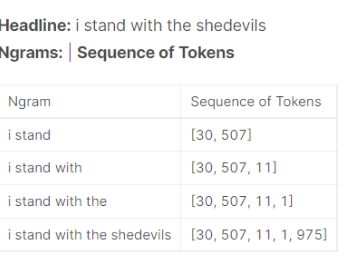

 Bu verileri bir öğrenme modeline girmek için tahmin ediciler oluşturmamız ve etiketlememiz gerekiyor. N-gram dizisini öngörücü olarak ve N-gramın bir sonraki kelimesini etiket olarak oluşturacağız. Örneğin:

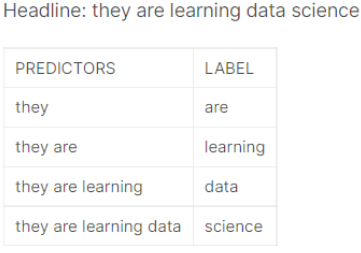

model eğitimi için  X girdi vektörünü ve Y etiket vektörünü elde edebiliriz. Son deneyler, tekrarlayan sinir ağlarının, öğrenme ve metin veri uygulamalarını sıralamak için sırayla iyi bir performans gösterdiğini göstermiştir.

In [ ]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences]) #girilen inputun maximum değeri alınır.
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1] #tahmin ve etiketlere ayrılır.
    label = np_utils.to_categorical(label, num_classes=total_words) #etiketler kategorik verilere çevrilir.
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [ ]:
def create_model(max_sequence_len, total_words):#model oluşturulur
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))
    

    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 10)            24220     
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 2422)              244622    
                                                                 
Total params: 313,242
Trainable params: 313,242
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(predictors, label, epochs=300, verbose=5)
# Final evaluation of the model
scores = model.evaluate(predictors, label, verbose=5)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoch 4/300
Epoch 5/300
Epoch 6/300
Epoch 7/300
Epoch 8/300
Epoch 9/300
Epoch 10/300
Epoch 11/300
Epoch 12/300
Epoch 13/300
Epoch 14/300
Epoch 15/300
Epoch 16/300
Epoch 17/300
Epoch 18/300
Epoch 19/300
Epoch 20/300
Epoch 21/300
Epoch 22/300
Epoch 23/300
Epoch 24/300
Epoch 25/300
Epoch 26/300
Epoch 27/300
Epoch 28/300
Epoch 29/300
Epoch 30/300
Epoch 31/300
Epoch 32/300
Epoch 33/300
Epoch 34/300
Epoch 35/300
Epoch 36/300
Epoch 37/300
Epoch 38/300
Epoch 39/300
Epoch 40/300
Epoch 41/300
Epoch 42/300
Epoch 43/300
Epoch 44/300
Epoch 45/300
Epoch 46/300
Epoch 47/300
Epoch 48/300
Epoch 49/300
Epoch 50/300
Epoch 51/300
Epoch 52/300
Epoch 53/300
Epoch 54/300
Epoch 55/300
Epoch 56/300
Epoch 57/300
Epoch 58/300
Epoch 59/300
Epoch 60/300
Epoch 61/300
Epoch 62/300
Epoch 63/300
Epoch 64/300
Epoch 65/300
Epoch 66/300
Epoch 67/300
Epoch 68/300
Epoch 69/300
Epoch 70/300
Epoch 71/300
Epoch 72/300
Epoch 73/300
Epoch 74/300
Epoch 75/300
Epoch 76/300
Epoch 77/300
Epoch 78

In [ ]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):#verilen kelimeden sonraki kelimeyi tahmin etmek için
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)        
        predicted=np.argmax(predicted,axis=1)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()
#test kısmında , kelime verilir ve sonrasında 5 yada 4 tane kelime üretmesi istenir.
print (generate_text("united states", 5, model, max_sequence_len))
print (generate_text("president trump", 4, model, max_sequence_len))
print (generate_text("donald trump", 4, model, max_sequence_len))
print (generate_text("india and china", 4, model, max_sequence_len))
print (generate_text("new york", 4, model, max_sequence_len))
print (generate_text("science and technology", 5, model, max_sequence_len))    

United States Logos At Own Risk Control
President Trump Stolen Philosophys Critical Tools
Donald Trump As Be Tomboys May
India And China Players On The Finale
New York Today A Holocaust Survivors
Science And Technology King Came Out Against Vietnam
